In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load admissions data
df_adm = pd.read_csv('../mimic/ADMISSIONS.csv')
df_adm.ADMITTIME = pd.to_datetime(df_adm.ADMITTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
df_adm.DISCHTIME = pd.to_datetime(df_adm.DISCHTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
df_adm.DEATHTIME = pd.to_datetime(df_adm.DEATHTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')

In [3]:
# sort by subject, then admit times
df_adm = df_adm.sort_values(['SUBJECT_ID','ADMITTIME'])
df_adm = df_adm.reset_index(drop = True)

# add columns for next admission time and type
df_adm['NEXT_ADMITTIME'] = df_adm.groupby('SUBJECT_ID').ADMITTIME.shift(-1)
df_adm['NEXT_ADMISSION_TYPE'] = df_adm.groupby('SUBJECT_ID').ADMISSION_TYPE.shift(-1)

In [4]:
# Don't count appointments (only emergencies)
rows = df_adm.NEXT_ADMISSION_TYPE == 'ELECTIVE'
df_adm.loc[rows,'NEXT_ADMITTIME'] = pd.NaT
df_adm.loc[rows,'NEXT_ADMISSION_TYPE'] = np.NaN

df_adm = df_adm.sort_values(['SUBJECT_ID','ADMITTIME'])

In [5]:
#When we filter out the "ELECTIVE", we need to correct the next admit time for these admissions since there might be 'emergency' next admit after "ELECTIVE"
df_adm[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']] = df_adm.groupby(['SUBJECT_ID'])[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']].fillna(method = 'bfill')
# calculate days until next admission
df_adm['DAYS_NEXT_ADMIT']=  (df_adm.NEXT_ADMITTIME - df_adm.DISCHTIME).dt.total_seconds()/(24*60*60)
# Set output label to 1 if next admission is within 30 days, and 0 else.
df_adm['OUTPUT_LABEL'] = (df_adm.DAYS_NEXT_ADMIT < 30).astype('int')

In [6]:
# Filter out newborn and death; these are not relavent
df_adm = df_adm[df_adm['ADMISSION_TYPE']!='NEWBORN']
df_adm = df_adm[df_adm.DEATHTIME.isnull()]
df_adm['DURATION'] = (df_adm['DISCHTIME']-df_adm['ADMITTIME']).dt.total_seconds()/(24*60*60)

In [7]:
# sample of values
df_adm.sample(4)

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE,DAYS_NEXT_ADMIT,OUTPUT_LABEL,DURATION
50052,50053,71921,156938,2179-03-12 07:15:00,2179-03-16 12:36:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,SNF,Medicare,...,NaN,NaN,RIGHT HIP PAIN/SDA,0,0,NaT,NaN,NaN,0,4.222917
16381,16382,13355,140880,2159-05-08 16:38:00,2159-05-10 16:10:00,NaT,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME WITH HOME IV PROVIDR,Private,...,NaN,NaN,SHORT GUT SYNDROME\ TUNNELLED CATHETER,0,1,2159-06-11 12:00:00,EMERGENCY,31.826389,0,1.980556
9218,9219,7535,151208,2177-01-28 01:55:00,2177-01-30 21:47:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,...,2177-01-27 22:08:00,2177-01-28 02:45:00,T8 FRACTURE WITH CORD COMPRESSION,0,1,NaT,NaN,NaN,0,2.827778
42394,42395,48253,196415,2169-09-08 22:44:00,2169-09-15 14:30:00,NaT,EMERGENCY,CLINIC REFERRAL/PREMATURE,SNF,Medicare,...,2169-09-08 16:18:00,2169-09-08 23:46:00,C-SPINE FRACTURES,0,1,NaT,NaN,NaN,0,6.656944


In [8]:
# Load doctor/nurse notes
df_notes = pd.read_csv('../mimic/NOTEEVENTS.csv')

/anaconda/envs/py35/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
# Merge notes with admissions information
df_notes = df_notes.sort_values(by=['SUBJECT_ID','HADM_ID','CHARTDATE'])
df_adm_notes = pd.merge(df_adm[['SUBJECT_ID','HADM_ID','ADMITTIME','DISCHTIME','DAYS_NEXT_ADMIT','NEXT_ADMITTIME','ADMISSION_TYPE','DEATHTIME','OUTPUT_LABEL','DURATION']],
                        df_notes[['SUBJECT_ID','HADM_ID','CHARTDATE','TEXT','CATEGORY']], 
                        on = ['SUBJECT_ID','HADM_ID'],
                        how = 'left')

In [10]:
# Admit time format is something like "2126-10-24 18:42:00". We don't need the exact time.
# Here, we keep only the first part, and format it to our liking
df_adm_notes['ADMITTIME_C'] = df_adm_notes.ADMITTIME.apply(lambda x: str(x).split(' ')[0])
df_adm_notes['ADMITTIME_C'] = pd.to_datetime(df_adm_notes.ADMITTIME_C, format = '%Y-%m-%d', errors = 'coerce')
# Also format chart date
# df_adm_notes['CHARTDATE'] = pd.to_datetime(df_adm_notes.CHARTDATE, format = '%Y-%m-%d', errors = 'coerce')

In [11]:
df_adm_notes.sample(4)

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DAYS_NEXT_ADMIT,NEXT_ADMITTIME,ADMISSION_TYPE,DEATHTIME,OUTPUT_LABEL,DURATION,CHARTDATE,TEXT,CATEGORY,ADMITTIME_C
289899,13218,177218,2200-10-12 15:09:00,2200-11-17 14:17:00,NaN,NaT,EMERGENCY,NaT,0,35.963889,2200-10-28,Resp Note: Pt received on ordered vent setting...,Nursing/other,2200-10-12
497238,22961,157937,2146-12-26 21:10:00,2147-01-24 13:20:00,NaN,NaT,EMERGENCY,NaT,0,28.673611,2147-01-09,cv:hr 76-87 vpaced no ectopy.sbp 108-131/45-52...,Nursing/other,2146-12-26
200266,9021,178275,2167-07-27 18:53:00,2167-09-09 14:35:00,NaN,NaT,EMERGENCY,NaT,0,43.820833,2167-08-14,[**2167-8-14**] 5:37 AM\n CHEST (PORTABLE AP) ...,Radiology,2167-07-27
917144,62914,122104,2113-03-07 10:30:00,2113-03-31 14:49:00,NaN,NaT,ELECTIVE,NaT,0,24.179861,2113-03-11,Demographics\n Day of intubation: [**2113-3-...,Respiratory,2113-03-07


In [12]:
# Distribution of notes per patient stay
print('Distribution of notes per patient')
print('Mean:', df_adm_notes.groupby(['SUBJECT_ID', 'HADM_ID']).size().mean())
print('Median:', df_adm_notes.groupby(['SUBJECT_ID', 'HADM_ID']).size().median())
print('Std dev:', df_adm_notes.groupby(['SUBJECT_ID', 'HADM_ID']).size().std())

Distribution of notes per patient
Mean: 26.529335186778756
Median: 14.0
Std dev: 42.88011759253797


In [13]:
# Number of notes per type
# We see that ther are 50k discharge summaries, and many many more other note types
df_adm_notes.groupby('CATEGORY').size()

CATEGORY
Case Management         825
Consult                  68
Discharge summary     50072
ECG                  119904
Echo                  28458
General                5938
Nursing              185878
Nursing/other        348592
Nutrition              7419
Pharmacy                 84
Physician            115640
Radiology            307945
Rehab Services         4926
Respiratory           24432
Social Work            1969
dtype: int64

In [14]:
# Calcualte average number of discharge summaries per patient stay. These are mostly repeats
df_adm_notes.loc[df_adm_notes.CATEGORY=='Discharge summary'].groupby(['SUBJECT_ID', 'HADM_ID']).size().mean()

1.141112123974476

In [15]:
# If Discharge Summary 
df_discharge = df_adm_notes[df_adm_notes['CATEGORY'] == 'Discharge summary']
# multiple discharge summary for one admission -> after examination -> replicated summary -> replace with the last one 
df_discharge = (df_discharge.groupby(['SUBJECT_ID','HADM_ID']).nth(-1)).reset_index()
df_discharge = df_discharge[df_discharge['TEXT'].notnull()]

In [16]:
# If not discharge summary
df_not_discharge_note = df_adm_notes[df_adm_notes['CATEGORY'] != 'Discharge summary']
df_not_discharge_note = df_not_discharge_note[df_not_discharge_note['TEXT'].notnull()]

In [17]:
# Count number of extra notes per stay we have
# For discharge notes, we have exactly 1 per stay
print('Mean: ', df_not_discharge_note.groupby(['SUBJECT_ID', 'HADM_ID']).size().mean())
print('Median: ', df_not_discharge_note.groupby(['SUBJECT_ID', 'HADM_ID']).size().median())
print('Std Dev: ', df_not_discharge_note.groupby(['SUBJECT_ID', 'HADM_ID']).size().std())

Mean:  25.695951823352292
Median:  13.0
Std Dev:  42.973249935310164


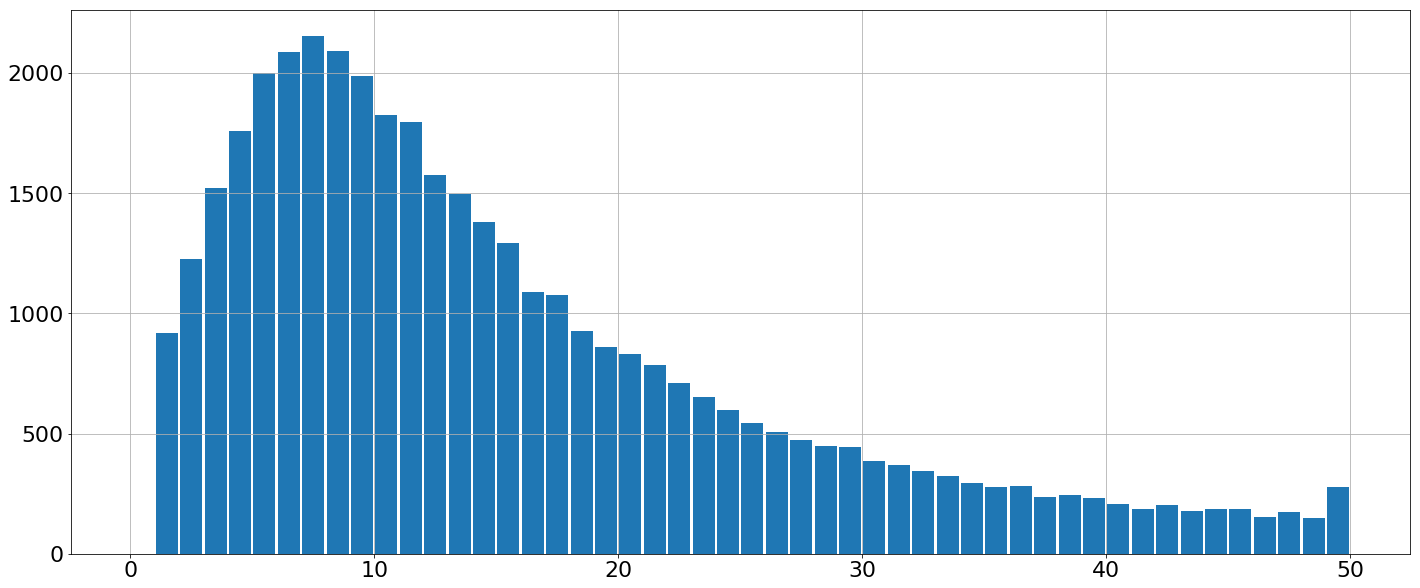

In [18]:
plt.rcParams.update({'font.size': 22})
df_not_discharge_note.groupby(['SUBJECT_ID', 'HADM_ID']).size().hist(
    bins=50, range=(0,50), figsize=(24,10), rwidth=0.9, grid=True
)#, color='#86bf91')

In [19]:
df_all_note = pd.concat([df_discharge, df_not_discharge_note])
df_all_note = df_all_note.sort_values('CHARTDATE')

In [20]:
# concatenate all notes together to one big boi
df_concat = pd.DataFrame(df_all_note.groupby('HADM_ID')['TEXT'].apply(lambda x: "%s" % ' '.join(x))).reset_index()
df_concat['OUTPUT_LABEL'] = df_concat['HADM_ID'].apply(lambda x: df_all_note[df_all_note['HADM_ID']==x].OUTPUT_LABEL.values[0])

In [21]:
# Concatenate all notes together to one big boi
# Separated by magic separator ' "&-o.o-&" '
# groupby preserves order, so discharge note will be at end hopefully
df_concat_char = pd.DataFrame(df_all_note.groupby('HADM_ID')['TEXT'].apply(lambda x: "%s" % ' "&-o.o-&" '.join(x))).reset_index()
df_concat_char['OUTPUT_LABEL'] = df_concat_char['HADM_ID'].apply(lambda x: df_all_note[df_all_note['HADM_ID']==x].OUTPUT_LABEL.values[0])

In [22]:
# df_concat_ord = pd.DataFrame(df_all_note.groupby('HADM_ID').apply(
#     lambda x: x['TEXT'].apply(
#         lambda y : "%s" % ' "&-o.o-&" '.join(
#         x.sort_values('CHARTDATE')['TEXT'])))).reset_index()
# df_concat_ord['OUTPUT_LABEL'] = df_concat_ord['HADM_ID'].apply(lambda x: df_all_note[df_all_note['HADM_ID']==x].OUTPUT_LABEL.values[0])



In [23]:
import re
from tqdm import tqdm

In [24]:
# string preprocessing script, clean up text
def preprocess1(x):
    y=re.sub('\\[(.*?)\\]','',x) #remove de-identified brackets
    y=re.sub('[0-9]+\.','',y) #remove 1.2. since the segmenter segments based on this
    y=re.sub('dr\.','doctor',y)
    y=re.sub('m\.d\.','md',y)
    y=re.sub('admission date:','',y)
    y=re.sub('discharge date:','',y)
    y=re.sub('--|__|==','',y)
    return y

In [25]:
def preprocessing(df_less_n): 
    # text processing
    df_less_n['TEXT']=df_less_n['TEXT'].fillna(' ')
    df_less_n['TEXT']=df_less_n['TEXT'].str.replace('\n',' ')
    df_less_n['TEXT']=df_less_n['TEXT'].str.replace('\r',' ')
    df_less_n['TEXT']=df_less_n['TEXT'].apply(str.strip)
    df_less_n['TEXT']=df_less_n['TEXT'].str.lower()

    df_less_n['TEXT']=df_less_n['TEXT'].apply(lambda x: preprocess1(x))
    return df_less_n

# turn into many many chunks of size 318
# if one_chunk=True, takes only one chunk per note
def chunk_up(df_less_n, one_chunk=False):
    #to get 318 words chunks for readmission tasks
    df_len = len(df_less_n)
    want=pd.DataFrame({'ID':[],'TEXT':[],'Label':[]})
    for i in tqdm(range(df_len)):
        x=df_less_n.TEXT.iloc[i].split()
        
        n=int(len(x)/318)
        if one_chunk:
            n = 1
        
        for j in range(n):
            want=want.append({'TEXT':' '.join(x[j*318:(j+1)*318]),'Label':df_less_n.OUTPUT_LABEL.iloc[i],'HADM_ID':df_less_n.HADM_ID.iloc[i], 'ID':i},ignore_index=True)
        if len(x)%318>10:
            want=want.append({'TEXT':' '.join(x[-(len(x)%318):]),'Label':df_less_n.OUTPUT_LABEL.iloc[i],'HADM_ID':df_less_n.HADM_ID.iloc[i], 'ID':i},ignore_index=True)
    
    return want

In [26]:
df_processed = preprocessing(df_concat_char)

In [27]:
### An example to get the train/test/split with random state:
### note that we divide on patient admission level and share among experiments, instead of notes level. 
### This way, since our methods run on the same set of admissions, we can see the
### progression of readmission scores. 

readmit_ID = df_adm[df_adm.OUTPUT_LABEL == 1].HADM_ID
not_readmit_ID = df_adm[df_adm.OUTPUT_LABEL == 0].HADM_ID
#subsampling to get the balanced pos/neg numbers of patients for each dataset
not_readmit_ID_use = not_readmit_ID.sample(n=len(readmit_ID), random_state=1)
id_val_test_t=readmit_ID.sample(frac=0.2,random_state=1)
id_val_test_f=not_readmit_ID_use.sample(frac=0.2,random_state=1)

id_train_t = readmit_ID.drop(id_val_test_t.index)
id_train_f = not_readmit_ID_use.drop(id_val_test_f.index)

id_val_t=id_val_test_t.sample(frac=0.5,random_state=1)
id_test_t=id_val_test_t.drop(id_val_t.index)

id_val_f=id_val_test_f.sample(frac=0.5,random_state=1)
id_test_f=id_val_test_f.drop(id_val_f.index)

In [28]:
# test if there is overlap between train and test, should return "array([], dtype=int64)"
(pd.Index(id_test_t).intersection(pd.Index(id_train_t))).values

array([], dtype=int64)

In [29]:
id_test = pd.concat([id_test_t, id_test_f])
test_id_label = pd.DataFrame(data = list(zip(id_test, [1]*len(id_test_t)+[0]*len(id_test_f))), columns = ['id','label'])

id_val = pd.concat([id_val_t, id_val_f])
val_id_label = pd.DataFrame(data = list(zip(id_val, [1]*len(id_val_t)+[0]*len(id_val_f))), columns = ['id','label'])

id_train = pd.concat([id_train_t, id_train_f])
train_id_label = pd.DataFrame(data = list(zip(id_train, [1]*len(id_train_t)+[0]*len(id_train_f))), columns = ['id','label'])


In [30]:
#get discharge train/val/test

discharge_train = df_processed[df_processed.HADM_ID.isin(train_id_label.id)]
discharge_val = df_processed[df_processed.HADM_ID.isin(val_id_label.id)]
discharge_test = df_processed[df_processed.HADM_ID.isin(test_id_label.id)]

In [31]:
# Train, val, test set size:
# Note these are smaller since we undersample negative examples
print('Train:', len(discharge_train))
print('Val:', len(discharge_val))
print('Test:', len(discharge_test))

# Percentage of pos/neg examples:
print(discharge_train.OUTPUT_LABEL.mean())
print(discharge_val.OUTPUT_LABEL.mean())
print(discharge_test.OUTPUT_LABEL.mean())

Train: 4734
Val: 591
Test: 593
0.5002112378538234
0.5008460236886633
0.4991568296795953


In [32]:
discharge_train.to_csv('./data/all_notes_ordered/train.csv')
discharge_val.to_csv('./data/all_notes_ordered/val.csv')
discharge_test.to_csv('./data/all_notes_ordered/test.csv')

In [33]:
discharge_train.sample(1)

,HADM_ID,TEXT,OUTPUT_LABEL
10741,123730,atrial fibrillation with rapid ventricular res...,0
